# 실습 요구사항

- 2개 카테고리로 분류
- 2개의 모델로 학습
  - vanila CNN <-- 정확도는 무시
  - 전이학습
- 각 모델에 대하여
  - 로스 그래프를 실시간으로 그린다.
  - 100 epoch 이상
  - 50 epoch까지 오버피팅이 발생하지 않는다.
  - 정확도 95%
  - 파라매터 갯수가 1000만개 미만으로



# TODO

- ~데이터~
  - ~다운로드~
  - ~압축 풀기~
  - ~Keras 폴더 구성~
  - ~파일 복사~

- Vanial CNN
  - ~데이터 로딩~
  - ~코드 수정~
  - ~실시간 로스 보기~

- 전이학습
  - ~데이터 로딩~
  - ~전이학습 코드 수정~
  - ~실시간 로스 보기~
  - ~모델 크기 조정~ <-- 1040까지 줄였다.
  - ~오버피팅 완화~
  - ~성능 확보~




# 데이터

In [1]:
!wget https://github.com/dhrim/t-academy_2021/raw/master/material/deep_learning/practice/2flowers.zip

--2021-08-18 01:27:43--  https://github.com/dhrim/t-academy_2021/raw/master/material/deep_learning/practice/2flowers.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/t-academy_2021/master/material/deep_learning/practice/2flowers.zip [following]
--2021-08-18 01:27:43--  https://raw.githubusercontent.com/dhrim/t-academy_2021/master/material/deep_learning/practice/2flowers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19768598 (19M) [application/zip]
Saving to: ‘2flowers.zip’

2flowers.zip        100%[===================>]  18.85M  --.-KB/s    in 0.1s    

2021-08-18 01:27:43 (17

In [ ]:
!unzip 2flowers.zip

## Keras 표준 디렉토리 구조로 준비

```
2flowers/
  daisy/
  dandeliion/
```
위 구조로 있던 파일들을 가지고 아래의 Keras 표준 구조로 만든다.

```
prepared/
  train/
    daisy/
    dandeliion/
  test/
    daisy/
    dandeliion/
```


In [5]:
!mkdir 2flowers

!mv daisy 2flowers/
!mv dandelion 2flowers/

In [18]:
!rm -rf prepared

!mkdir -p prepared/train/daisy
!mkdir -p prepared/train/dandelion
!mkdir -p prepared/test/daisy
!mkdir -p prepared/test/dandelion

In [19]:
import glob
import os
import random
import shutil

base_path = "2flowers"

# 2flowers/daisy/*.jpg 파일들을 
# preapred/train/daisy/ 과  prepared/test/daisy/에 8:2로 카피한다.
# category_name에는 카테고리 이름 'daisy'와 'dandeliion'이 전달된다.
def copy_files(category_name):

  path = os.path.join(base_path, category_name, "*")
  print(path)
  # path = "2flowers/daisy/*"

  # 폴더 밑의 파일이름 구하기
  file_list = glob.glob(path)
  print(file_list[:5])
  # file_list = ['2flowers/daisy/430.jpg', ... ]
  print(len(file_list))

  # 파일 리스트를 섞어주고
  random.shuffle(file_list)


  # 8:2가 되는 인덱스를 구한다.
  # len(file_list) = 262 -> split_index = 209
  split_index = int(len(file_list)*0.8)


  # 각 파일들을 카피한다.
  for i in range(len(file_list)):
    if i < split_index:
      dst = os.path.join("prepared", "train", category_name)
    else:
      dst = os.path.join("prepared", "test", category_name)

    shutil.copy(file_list[i], dst)


copy_files("daisy")
copy_files("dandelion")

2flowers/daisy/*
['2flowers/daisy/4301689054_20519e5b68_jpg.rf.f66c5ddb62999312cda46fa048756c8e.jpg', '2flowers/daisy/5110109540_beed4ed162_m_jpg.rf.0e548287e9400187aee869a511461b1d.jpg', '2flowers/daisy/909609509_a05ccb8127_jpg.rf.f9b8336eddf3d1d80dc74d29e594c41c.jpg', '2flowers/daisy/4923279674_e7f8e70794_n_jpg.rf.2c1fd1168d1e627a776aa89093617099.jpg', '2flowers/daisy/2635314490_e12d3b0f36_m_jpg.rf.3922030582696dc1a59cd0fc30a470cc.jpg']
262
2flowers/dandelion/*
['2flowers/dandelion/645330051_06b192b7e1_jpg.rf.7614736767cc162d46f2eac9c9cc79de.jpg', '2flowers/dandelion/3419166382_a5e4b8fe6d_m_jpg.rf.3676b2f0d3c8655d84ad3201cadacdfe.jpg', '2flowers/dandelion/2625836599_03e192266f_jpg.rf.ee6860170a708464750eeb49a817ba50.jpg', '2flowers/dandelion/2637883118_cf6ce37be4_n_jpg.rf.8aa4a688148aaf53635d36f3fc9a2a88.jpg', '2flowers/dandelion/5646743865_a8f20b60f7_n_jpg.rf.c10e8602d5eb5c83b569945e61f721dc.jpg']
302


In [20]:
!ls -al prepared/train/daisy/* | wc
!ls -al prepared/test/daisy/* | wc
!ls -al prepared/train/dandelion/* | wc
!ls -al prepared/test/dandelion/* | wc

    209    1881   27402
     53     477    6846
    241    2169   32288
     61     549    8108


# loss 그리기 callback

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])


# Vanilla CNN

## 모델 정의

수정할 사항
- 입력 사이즈
- 출력층 노드 수


In [58]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Reshape, BatchNormalization


model = keras.Sequential()

model.add(Input((224,224,3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 112, 112, 64)    

## ImageDataGenerator 생성

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      rescale=1./255,
      # preprocessing_function=efficientnet.preprocess_input
).flow_from_directory(
      "prepared/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      rescale=1./255,    
      # preprocessing_function=efficientnet.preprocess_input
).flow_from_directory(
      "prepared/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)


Found 450 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


## 학습

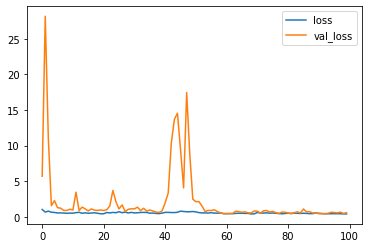

loss =  0.4119311273097992 , val_loss =  0.5816788673400879


In [60]:
plot_losses = PlotLosses()

model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      validation_steps=test_data_generator.samples/64,      
      epochs=100,
      callbacks=[plot_losses]
)

## 평가

In [62]:
loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)


1/1 [==============================] - 1s 251ms/step - loss: 0.5817 - accuracy: 0.7456
loss= 0.5816788673400879
acc= 0.7456140518188477


## 예측

In [63]:

y_ = model.predict(
      test_data_generator,
      steps=test_data_generator.samples/64
)

custom_labels = list(test_data_generator.class_indices.keys())
predicted = np.argmax(y_, axis=1)
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


predicted category index = 1
predicted category name = dandelion


## 로스 그리기 callback

In [25]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



# 전이학습

## 모델 정의

다름 모델 사용 시에 수정해야 할 사항
- import의 모듈 이름
- import의 클래스 이름
- conv layers 로딩 시의 클래스 이름
- 2곳의 preprocess_input의 모듈 이름
- train 데이터 폴더 이름
- test 데이터 폴더 이름
- 모델 출력층의 노드 갯수

In [49]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2


conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(39, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
flatten_13 (Flatten)         (None, 68992)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 39)                2690727   
_________________________________________________________________
batch_normalization_18 (Batc (None, 39)                156       
_________________________________________________________________
dropout_20 (Dropout)         (None, 39)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 30)                1200      
_________________________________________________________________
batch_normalization_19 (Batc (None, 30)              

## ImageDataGenerator 생성

In [ ]:

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=efficientnet.preprocess_input
).flow_from_directory(
      "prepared/train",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=efficientnet.preprocess_input
).flow_from_directory(
      "prepared/test",
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)


## 학습

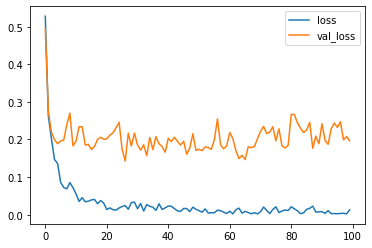

loss =  0.012694370932877064 , val_loss =  0.19664305448532104


In [50]:
plot_losses = PlotLosses()

model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      steps_per_epoch=train_data_generator.samples/64,  
      validation_steps=test_data_generator.samples/64,      
      epochs=100,
      callbacks=[plot_losses]
)



## 평가

In [51]:
loss, acc = model.evaluate(
      test_data_generator,
      steps=test_data_generator.samples/64
)
print("loss=", loss)
print("acc=", acc)


1/1 [==============================] - 1s 286ms/step - loss: 0.1966 - acc: 0.9561
loss= 0.19664306938648224
acc= 0.9561403393745422


## 예측

In [52]:

y_ = model.predict(
      test_data_generator,
      steps=test_data_generator.samples/64
)

custom_labels = list(test_data_generator.class_indices.keys())
predicted = np.argmax(y_, axis=1)
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


predicted category index = 1
predicted category name = dandelion
